In [1]:
import keras, string, itertools, random, datetime, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from string import punctuation
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.layers import Embedding, Conv1D, Flatten, Dense, Dropout, LSTM, Bidirectional, TimeDistributed, Dropout

Using TensorFlow backend.


In [2]:
# Define custom functions
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    Description: Prints and plots the confusion matrix.	Normalization can be applied by setting `normalize=True`

    Args:
    - cm: Confusion Matrix
    - classes: Names of classes
    - normalize: Whether to or to not normal values in Confusion Matrix
    - cmap: Plot color	
    '''

    # Check if normalize is true or false
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Format axis and plot Confusion Matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

def chunk_seq(seq, chunk_len):
    chunked_seq = []
    for i in range(0, len(seq), chunk_len):
        chunked_seq.append(seq[i:i+chunk_len])
    return chunked_seq

def get_labels(seq):
    labels_seq = []
    seq = seq.split()
    for i in range(len(seq)):
        if ',' in seq[i]:
            labels_seq.append('<comma>')
        elif '.' in seq[i]:
            labels_seq.append('<period>')
        else:
            labels_seq.append('<na>')
    return labels_seq

In [3]:
# Set model parameters
name_1 = 'lstm'
name_2 = 'cnn-lstm'
model_name = name_2
max_seq_len = 30
drop_prob = 0.2
no_filters_1 = 64
no_filters_2 = 128
kernel_1 = 3
kernel_2 = 5
lstm_hidden = 512
embed_dim = 256
adam_lr = 0.001
batch_size = 32
epochs = 1
valid_split = 0.3

In [4]:
# Set misc parameters
current = datetime.datetime.now()
date = current.strftime('%b-%d')
tensor_b = TensorBoard(log_dir='./tf_logs/{}'.format(model_name), batch_size=batch_size, write_graph=True, histogram_freq=0)
early_s = EarlyStopping(monitor='val_loss')
class_names = ['Pad', 'NA', 'Comma', 'Period']

# Look-up table to remove punctuations from data
table = str.maketrans('', '', punctuation)

In [5]:
# Load and process input/label data
data = open('./data/processed/ted_data', 'r', encoding='utf-8').read()
data = data.lower()
data_split = data.split('\n')
all_data = ' '.join(data_split)
words = all_data.split()

# Chunk sequence
x = chunk_seq(words, max_seq_len)
sequences = [' '.join(seq) for seq in x]

# Get sequence labels
process_labels = [get_labels(seq) for seq in sequences]
process_labels = [' '.join(seq) for seq in process_labels]

# Remove punctuations
sequences = [seq.translate(table) for seq in sequences]

with open('./processed_input', 'w', encoding='utf-8') as f:
    for x in sequences:
        f.write(x+'\n')

with open('./processed_labels', 'w', encoding='utf-8') as f:
    for x in process_labels:
        f.write(x+'\n')

# Check number of sequences and labels
print('Number of sequences: \t{}'.format(len(sequences)))
print('Number of labels: \t{}'.format(len(process_labels)))

y_labels = open('./processed_labels', 'r', encoding='utf-8').read()
y_labels = y_labels.split('\n')
y_labels = y_labels[:-1]
all_labels = ' '.join(y_labels)
labels_tag = all_labels.split()

split = int(0.8*len(all_labels))
test_y_counts = all_labels[split:]
test_y_counts_split = test_y_counts.split()
counts = Counter(test_y_counts_split)

Number of sequences: 	167697
Number of labels: 	167697


In [6]:
# Build words vocab
all_data = ' '.join(sequences)
words = all_data.split()
words_in_vocab = Counter(words)
vocab = sorted(words_in_vocab, key=words_in_vocab.get, reverse=True)

# Skip most common word
vocab_to_int = {word: index for index, word in enumerate(vocab, 2)}
vocab_to_int['-PAD-'] = 0  # The special value used for padding
vocab_to_int['-OOV-'] = 1  # The special value used for OOVs
unique_vocab = len(vocab_to_int)
print('Number of unique words:', unique_vocab)

# Build labels vocab
labels_in_vocab = Counter(labels_tag)
labels_vocab = sorted(labels_in_vocab, key=labels_in_vocab.get, reverse=True)
label_to_int = {t: i for i, t in enumerate(labels_vocab, 1)}
label_to_int['-PAD-'] = 0  # The special value used to padding

# Check labels
no_classes = len(label_to_int)
print('Class distribution:', Counter(labels_in_vocab))
print('Number of unique labels:', no_classes)
print(label_to_int)

Number of unique words: 108807
Class distribution: Counter({'<na>': 4387594, '<comma>': 354651, '<period>': 288658})
Number of unique labels: 4
{'<na>': 1, '<comma>': 2, '<period>': 3, '-PAD-': 0}


In [7]:
# Tokenize input sequences
seq_int = []
for seq in sequences:
    seq_int.append([vocab_to_int[word] for word in seq.split()])

# Pad input sequences
pad_seq = pad_sequences(sequences=seq_int, maxlen=max_seq_len, padding='post', value=0)

# Check sample sequence
print('Sample sequence:', sequences[-1])
print('Sample sequence:', pad_seq[-1])

# Tokenize output labels
lab_int = []
for lab in y_labels:
    lab_int.append([label_to_int[word] for word in lab.split()])

# Pad input labels
pad_labels = pad_sequences(sequences=lab_int, maxlen=max_seq_len, padding='post', value=0)
encoded_labels = [to_categorical(i, num_classes=no_classes) for i in pad_labels]

# Check sample label
print('Sample label:', pad_labels[-1])
print('Encoded label', encoded_labels[-1])

# Check max seq length
print("Maximum sequence length: {}".format(max_seq_len))

# Check that all sequences and labels are at max sequence length 
assert len(pad_seq)==len(seq_int)
assert len(pad_seq[0])==max_seq_len

assert len(pad_labels)==len(lab_int)
assert len(pad_labels[0])==max_seq_len
print('Sequence and labels length check passed!')

Sample sequence: day so it might be that this is not just a game it might be a way to decide our own fatethank youapplause
Sample sequence: [   142     17     13    170     29      7     14     10     31     46
      6    526     13    170     29      6     86      4   1222     42
    160 108806   9653      0      0      0      0      0      0      0]
Sample label: [3 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0 0]
Encoded label [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
Maximum sequence length: 30
Sequence and labels length check passed!


In [8]:
# Check that all sequences and labels are at max sequence length 
assert len(pad_seq)==len(seq_int)
assert len(pad_seq[0])==max_seq_len

assert len(pad_labels)==len(lab_int)
assert len(pad_labels[0])==max_seq_len

In [9]:
# Split train and label dataset
train_test_split_frac = 0.8
split_index = int(0.8*len(pad_seq))

# Split data into training, validation, and test data (features and labels, x and y)
train_val_x, test_x = pad_seq[:split_index], pad_seq[split_index:]
train_val_y, test_y = encoded_labels[:split_index], encoded_labels[split_index:]

# print out the shapes of your resultant feature data
print('Training/Validation Dataset: \t{}'.format(train_val_x.shape), len(train_val_y))
print('Testing Dataset: \t\t{}'.format(test_x.shape), len(test_y))

Training/Validation Dataset: 	(134157, 30) 134157
Testing Dataset: 		(33540, 30) 33540


In [10]:
# Model code
model = Sequential()
model.add(Embedding(input_dim=unique_vocab, output_dim=embed_dim, input_length=max_seq_len))
model.add(Conv1D(filters=no_filters_1, kernel_size=kernel_1, padding='SAME'))
model.add(Dropout(rate=drop_prob, seed=50))
model.add(Conv1D(filters=no_filters_2, kernel_size=kernel_2, padding="SAME"))
model.add(Dropout(rate=drop_prob, seed=50))
model.add(Bidirectional(LSTM(lstm_hidden, return_sequences=True)))
model.add(Dropout(rate=drop_prob, seed=50))
model.add(TimeDistributed(Dense(no_classes, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer=Adam(adam_lr), metrics=['accuracy'])#, ignore_class_accuracy(0)])
model.summary()
model.fit(x=train_val_x, y=np.array(train_val_y), batch_size=64, epochs=epochs, validation_split=valid_split, 
          steps_per_epoch=None, validation_steps=None,
          shuffle=True, verbose=1, callbacks=[tensor_b, early_s])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 256)           27854592  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 64)            49216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 128)           41088     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 1024)          2625536   
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 1024)          0         
__________

In [11]:
test_data = test_x[489]
pred_x_seq = []
for x in test_data:
    for value, index in vocab_to_int.items():
        if x == index:
            pred_x_seq.append(value)

# Predicted output
pred_expand = model.predict(np.expand_dims(test_data, axis=0))
pred_y = []
for y in pred_expand:
    pred_y.append(np.argmax(y, axis=1))
print('Predictions Index:')
print(pred_y)

pred_y_seq = []
for x in pred_y:
    for y in x:
        for value, index in label_to_int.items():
            if y == index:
                pred_y_seq.append(value)

combined = []
for i in range(len(pred_x_seq)):
    if pred_y_seq[i] == '<comma>':
        combined.append(str(pred_x_seq[i])+',')
    elif pred_y_seq[i] == '<period>':
        combined.append(str(pred_x_seq[i])+'.')
    else:
        combined.append(str(pred_x_seq[i]))

for i in range(len(combined)):
    if '.' in combined[i]:
        combined[i+1] = combined[i+1].capitalize()
    if combined[i] == 'i':
        combined[i] = combined[i].capitalize()
    else:
        continue
        
combined = ' '.join(combined)
combined

print('\n')
print('Prediction sequence:')            
print(' '.join(pred_x_seq))
print('\n')
print('Prediction output:')
print(' '.join(pred_y_seq))
print('\n')
print('Combined prediction:')
print(combined)

Predictions Index:
[array([1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 3, 1, 1, 1, 1, 1], dtype=int64)]
Prediction sequence:
kennedy school of government and i look at them and im like no i went to the murabit school of international affairs its extremely exclusive you would have to talk


Prediction output:
<na> <na> <na> <comma> <na> <na> <na> <na> <period> <na> <na> <na> <comma> <na> <na> <na> <na> <na> <na> <na> <na> <period> <na> <na> <period> <na> <na> <na> <na> <na>


Combined prediction:
kennedy school of government, and I look at them. And im like no, I went to the murabit school of international affairs. Its extremely exclusive. You would have to talk


Test dataset distribution: Counter({'<na>': 884201, '<comma>': 68090, '<period>': 56544})
[[     0      7      0      0]
 [     0 866925   6939   8007]
 [     0  36773  17147  13978]
 [     0  23212   3961  29251]]


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.94      0.98      0.96    881871
           2       0.61      0.25      0.36     67898
           3       0.57      0.52      0.54     56424

   micro avg       0.91      0.91      0.91   1006200
   macro avg       0.53      0.44      0.46   1006200
weighted avg       0.89      0.91      0.89   1006200

Normalized confusion matrix
[[0.         1.         0.         0.        ]
 [0.         0.98305194 0.0078685  0.00907956]
 [0.         0.5415918  0.25254058 0.20586762]
 [0.         0.41138523 0.07020062 0.51841415]]


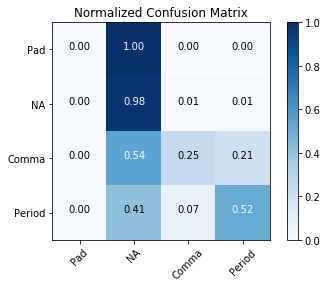

In [12]:
# Create confusion matrix and classification report
for_report = model.predict(test_x)
out_pred = [np.argmax(x, axis=1) for x in for_report]
out_pred = np.concatenate(out_pred, axis=0)

y_ = [np.argmax(x, axis=1) for x in test_y]
y_ = np.concatenate(y_, axis=0)

print('Test dataset distribution:', counts)
cm = confusion_matrix(y_true=y_, y_pred=out_pred)
print(cm)

cr = classification_report(y_true=y_, y_pred=out_pred)
print(cr)

plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()